# TRAFFIC SIGN CLASSIFIER

In [1]:
import pickle
import csv
import numpy as np
import scipy as sp
import pandas as pd
import sklearn as sk
from sklearn.utils import shuffle
from scipy import misc
from skimage import data, img_as_float
from skimage import exposure
import random
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow.contrib.layers import flatten
from skimage import color
from skimage import io

def Basic_Stats(x,name):
    
    # Print basic statisctics
    print ('*'*50)
    print ('Statistics of '+name)
    s=sp.stats.describe(x)
    print ('Minimum Class:', s[1][0] )
    print ('Max Class:', s[1][1])
    print ('Total Number of Observations:', s[0])
    print ('Mean:', s[2])
    print ('Std dev:', np.sqrt(s[3]))
    print ('*'*50)

def Plot_Histogram(x,n_classes):
    # Visualize distribution of classes
    n,batches, patches = plt.hist(x,n_classes,facecolor='green')
    plt.xticks(range(0,n_classes+1, 2), rotation='vertical')
    plt.xlabel('Signs')
    plt.ylabel ('Percent')
    plt.title ('Distribution of Classes')
    plt.show()

def augment_brightness_camera_images(image):
    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    random_bright = .25+np.random.uniform()
    #print(random_bright)
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1    
    
def jitter_image(img,ang_range,shear_range,trans_range):
    '''
    This function transforms images to generate new images.
    The function takes in following arguments,
    1- Image
    2- ang_range: Range of angles for rotation
    3- shear_range: Range of values to apply affine transform to
    4- trans_range: Range of values to apply translations over. 
    
    A Random uniform distribution is used to generate different parameters for transformation
    
    '''
    # Rotation

    ang_rot = np.random.uniform(ang_range)-ang_range/2
    rows,cols,ch = img.shape    
    Rot_M = cv2.getRotationMatrix2D((cols/2,rows/2),ang_rot,1)

    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    tr_y = trans_range*np.random.uniform()-trans_range/2
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])

    # Shear
    pts1 = np.float32([[5,5],[20,5],[5,20]])

    pt1 = 5+shear_range*np.random.uniform()-shear_range/2
    pt2 = 20+shear_range*np.random.uniform()-shear_range/2

    pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])

    shear_M = cv2.getAffineTransform(pts1,pts2)
        
    img = cv2.warpAffine(img,Rot_M,(cols,rows))
    img = cv2.warpAffine(img,Trans_M,(cols,rows))
    img = cv2.warpAffine(img,shear_M,(cols,rows))
    
    img = augment_brightness_camera_images(img)
        
    return img

def LeNet(x,keep_prob):    
    # Hyperparameters
    mu = 0
    sigma = 0.01
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5,5,1,6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Activation.
    conv1 = tf.nn.relu(conv1)
    
    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Activation.
    conv2 = tf.nn.relu(conv2)
   
    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Activation.
    fc1    = tf.nn.relu(fc1)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Activation.
    fc2    = tf.nn.relu(fc2)
    
    # Dropout
    fc2 = tf.nn.dropout(fc2, keep_prob)


    # Layer 5: Fully Connected. Input = 84. Output = 10.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits, conv1_W, conv2_W, fc1_W, fc2_W, fc3_W

from tensorflow.contrib.layers import flatten

def LeNet2(x,keep_prob):    
    # Hyperparameters
    mu = 0
    sigma = 0.1
    
    # TODO: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    W1 = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma), name="W1")
    x = tf.nn.conv2d(x, W1, strides=[1, 1, 1, 1], padding='VALID')
    b1 = tf.Variable(tf.zeros(6), name="b1")
    x = tf.nn.bias_add(x, b1)

    # TODO: Activation.
    x = tf.nn.relu(x)
    
    # TODO: Pooling. Input = 28x28x6. Output = 14x14x6.
    x = tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    layer1 = x
    
    # TODO: Layer 2: Convolutional. Output = 10x10x16.
    W2 = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma), name="W2")
    x = tf.nn.conv2d(x, W2, strides=[1, 1, 1, 1], padding='VALID')
    b2 = tf.Variable(tf.zeros(16), name="b2")
    x = tf.nn.bias_add(x, b2)
                     
    # TODO: Activation.
    x = tf.nn.relu(x)

    # TODO: Pooling. Input = 10x10x16. Output = 5x5x16.
    x = tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    layer2 = x
    
    # TODO: Layer 3: Convolutional. Output = 1x1x400.
    W3 = tf.Variable(tf.truncated_normal(shape=(5, 5, 16, 400), mean = mu, stddev = sigma), name="W3")
    x = tf.nn.conv2d(x, W3, strides=[1, 1, 1, 1], padding='VALID')
    b3 = tf.Variable(tf.zeros(400), name="b3")
    x = tf.nn.bias_add(x, b3)
                     
    # TODO: Activation.
    x = tf.nn.relu(x)
    layer3 = x

    # TODO: Flatten. Input = 5x5x16. Output = 400.
    layer2flat = flatten(layer2)
    
    # Flatten x. Input = 1x1x400. Output = 400.
    xflat = flatten(x)
    
    # Concat layer2flat and x. Input = 400 + 400. Output = 800
    x = tf.concat_v2([xflat, layer2flat], 1)
    
    # Dropout
    x = tf.nn.dropout(x, keep_prob)
    
    # TODO: Layer 4: Fully Connected. Input = 800. Output = 43.
    W4 = tf.Variable(tf.truncated_normal(shape=(800, 43), mean = mu, stddev = sigma), name="W4")
    b4 = tf.Variable(tf.zeros(43), name="b4")    
    logits = tf.add(tf.matmul(x, W4), b4)
    
    return logits, W1, W2, W3, W4


# Read Training and Test Data

training_file = 'train.p'
testing_file = 'test.p'
sign_name = 'signnames.csv'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

#Read sign names
sign_names=[]
f = open(sign_name)
csv_f = csv.reader(f)
for row in csv_f:
    sign_names.append(row)

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [2]:
# Basic statistics
n_train = len(X_train)
n_test = len(X_test)
image_shape = X_train.shape[1:]
n_classes = (len(np.unique(np.concatenate((train['labels'],test['labels'])))))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

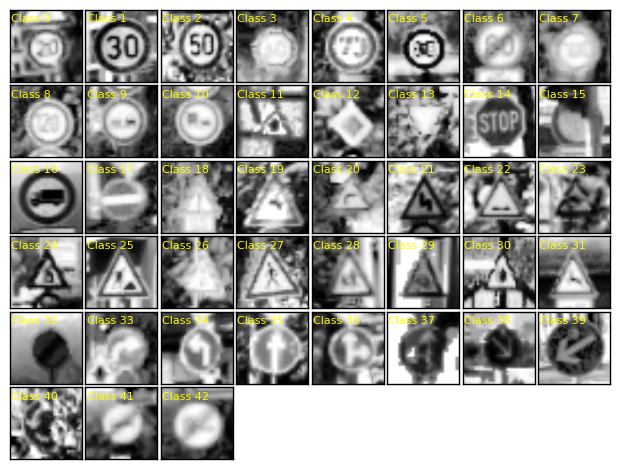

(32, 32, 3) 3072


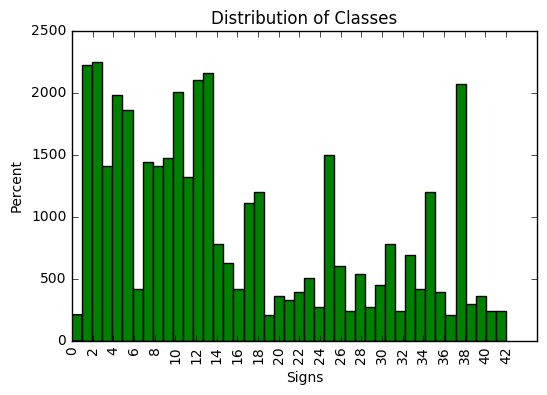

**************************************************
Statistics of Training Set
Minimum Class: 0
Max Class: 42
Total Number of Observations: 39209
Mean: 15.7883904206
Std dev: 12.0132375247
**************************************************


In [3]:
# Visualize One sign for each class
fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for i in np.arange(n_classes):
    index=(np.ndarray.tolist(y_train)).index(i)
    ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
    img=X_train[index,:,:,:]
    ax.imshow(cv2.equalizeHist(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)),cmap='gray')
    ax.text(0, 5, 'Class '+str(sign_names[i+1][0]),fontsize=8,color='yellow')
plt.show()

print (img.shape, img.size)

# Visualize distribution of classes
Plot_Histogram(y_train,n_classes)

# Print statistics of classes
Basic_Stats(y_train, 'Training Set')



----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [4]:
### Augument training data (exclude validation data)
AUGMENTATION_FACTOR=3
np.random.seed(100)
n,batches, patches = plt.hist(y_train,n_classes,facecolor='green')
train_data_length=len(X_train)*AUGMENTATION_FACTOR
target_obs_per_class=train_data_length/n_classes
Xtrain=X_train
ytrain=y_train
for i in np.arange(n_classes):
    if (n[i] < target_obs_per_class):
        index=(np.ndarray.tolist(y_train)).index(i)
        image= X_train[index]
        for j in np.arange(target_obs_per_class - n[i]):
            jitter_image(image,20,10,5)    
            Xtrain=np.append(Xtrain, [image],axis=0)
            ytrain=np.append(ytrain, [ytrain[index]],axis=0)
X_train=Xtrain
y_train=ytrain

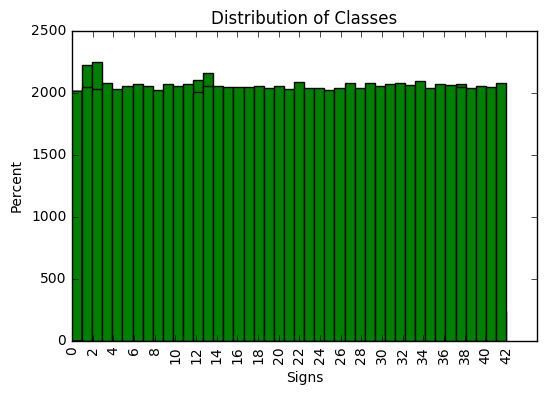

**************************************************
Statistics of Training Set
Minimum Class: 0
Max Class: 42
Total Number of Observations: 88236
Mean: 21.0355637155
Std dev: 12.4088883929
**************************************************


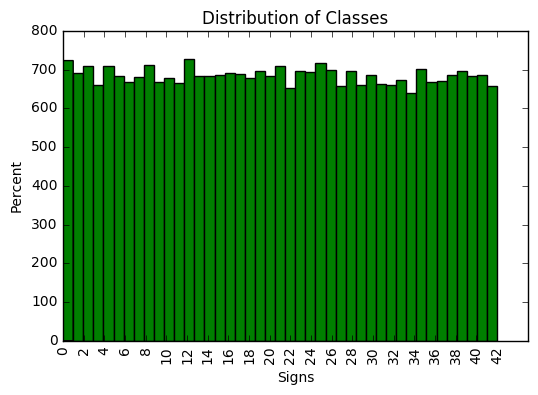

**************************************************
Statistics of Validation Set
Minimum Class: 0
Max Class: 42
Total Number of Observations: 29412
Mean: 20.8933088535
Std dev: 12.411839602
**************************************************


In [5]:
## Split data into training, validation and test:
## X_train_dev, y_train_dev = Training Set
## X_dev, y_dev = Validation Set
## X_test, y_test = Test Set

#X_train=X_train-np.mean(X_train)
#X_test=X_test-np.mean(X_test)

from sklearn.model_selection import train_test_split
X_train_dev, X_dev, y_train_dev, y_dev = train_test_split(X_train, y_train, random_state=42)

Plot_Histogram(y_train_dev,n_classes)
Basic_Stats(y_train_dev, 'Training Set')

Plot_Histogram(y_dev,n_classes)
Basic_Stats(y_dev, 'Validation Set')

In [6]:
### Grayscale, Equalize and Normalize Image

temp1 = (np.sum(X_train_dev/3, axis=3, keepdims=True))
temp2 = (np.sum(X_dev/3, axis=3, keepdims=True))
temp3 = (np.sum(X_test/3, axis=3, keepdims=True))

X_train_dev=temp1
X_dev=temp2
X_test=temp3

# Check input data
print ('Input data:', X_train_dev.shape, type(X_train_dev))
print ('Validation data:', X_dev.shape, type(X_dev))
print ('Test data:', X_test.shape,type(X_test))

print ('Input data:', y_train_dev.shape,type(y_train_dev))
print ('Validation data:', y_dev.shape,type(y_dev))
print ('Test data:', y_test.shape,type(y_test))

Input data: (88236, 32, 32, 1) <class 'numpy.ndarray'>
Validation data: (29412, 32, 32, 1) <class 'numpy.ndarray'>
Test data: (12630, 32, 32, 1) <class 'numpy.ndarray'>
Input data: (88236,) <class 'numpy.ndarray'>
Validation data: (29412,) <class 'numpy.ndarray'>
Test data: (12630,) <class 'numpy.ndarray'>


### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

### ANSWER

(a)First plot an image from each class. and note the variation in color. Greyscale and Normalize the Data to improve contrast for better feature detection. 

(b)Plot histograms of images to see the class distribution

(c)Augument the data by jittering the image randomly. The original data set is quite imbalanced, so all classes are augmented to reduce this imbalance and also increase the volume of the data set.

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

### ANSWER
(a) Training set was divided into a 25/75 validation split randomly by using Scikit Learn train-test function. 

(b)As mentioned above, the data set was augmented to reduce imbalance by jittering the images in a random fashion. A different number of images were added to each class, based on the number of images in the original class. The objective being, to have a level data set across all classes. This was successfully achieved as seen from the above histogram. Another constraint was to ensure that the validation set had approx 30,000 images as mentioned in the lectures

(c) A function jitter (originally inspired by Vivek Yadav's post: https://medium.com/@vivek.yadav/dealing-with-unbalanced-data-generating-additional-data-by-jittering-the-original-image-7497fe2119c3#.y8rtd9god), was implemented that randomly translates, scales, warps and brightness contrasts the original image. The transformation parameters were choosen to be not too large to ensure the image remains relatively recognizable. This jittering was 



In [7]:
EPOCHS = 30
BATCH_SIZE = 128

In [8]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, n_classes)

In [9]:
## Computation Graph with L2 Regularization
rate = 0.001
beta = 0.01

logits,weights_1,weights_2, weights_3,weights_4 = LeNet2(x, keep_prob)
predictions = tf.nn.softmax(logits)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
regularizers = tf.nn.l2_loss(weights_1) + tf.nn.l2_loss(weights_2) + tf.nn.l2_loss(weights_3)+tf.nn.l2_loss(weights_4)
loss_operation = tf.reduce_mean(cross_entropy+beta*regularizers)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [10]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    total_loss = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y,keep_prob: 1.0})
        loss = sess.run(loss_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
        total_loss += (loss * len(batch_x))
    return total_accuracy / num_examples, total_loss/num_examples

Training...

EPOCH 1 ...
Training Accuracy = 0.923
Training Loss = 3.684
Validation Accuracy = 0.917
Validation Loss = 3.701
EPOCH 2 ...
Training Accuracy = 0.966
Training Loss = 1.679
Validation Accuracy = 0.961
Validation Loss = 1.693
EPOCH 3 ...
Training Accuracy = 0.980
Training Loss = 0.878
Validation Accuracy = 0.975
Validation Loss = 0.892
EPOCH 4 ...
Training Accuracy = 0.985
Training Loss = 0.530
Validation Accuracy = 0.981
Validation Loss = 0.541
EPOCH 5 ...
Training Accuracy = 0.982
Training Loss = 0.376
Validation Accuracy = 0.979
Validation Loss = 0.385
EPOCH 6 ...
Training Accuracy = 0.987
Training Loss = 0.295
Validation Accuracy = 0.983
Validation Loss = 0.306
EPOCH 7 ...
Training Accuracy = 0.988
Training Loss = 0.259
Validation Accuracy = 0.986
Validation Loss = 0.269
EPOCH 8 ...
Training Accuracy = 0.989
Training Loss = 0.238
Validation Accuracy = 0.986
Validation Loss = 0.250
EPOCH 9 ...
Training Accuracy = 0.990
Training Loss = 0.227
Validation Accuracy = 0.987
Val

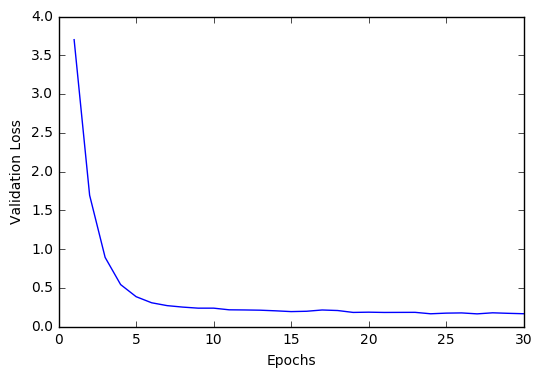

In [11]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train_dev)
    
    print("Training...")
    print()
    loss_plot=[]
    for i in range(EPOCHS):
        X_train_dev, y_train_dev = shuffle(X_train_dev, y_train_dev)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_dev[offset:end], y_train_dev[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
            
        training_accuracy,training_loss = evaluate(X_train_dev, y_train_dev)
        validation_accuracy, validation_loss = evaluate(X_dev, y_dev)
        print("EPOCH {} ...".format(i+1))
        print("Training Accuracy = {:.3f}".format(training_accuracy))
        print("Training Loss = {:.3f}".format(training_loss))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print("Validation Loss = {:.3f}".format(validation_loss))
        loss_plot=np.append(loss_plot,validation_loss)
        
    saver.save(sess, './lenet')
    print("Model saved")
    plt.plot(np.linspace(1,EPOCHS,EPOCHS),loss_plot)
    plt.xlabel('Epochs')
    plt.ylabel ('Validation Loss')
    plt.show()

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


### ANSWER
(a) The original architecture tried was LeNet as suggested above from the Udacity class, with the following additions 
    - L2 Regularization added to all weights
    - Dropout added to the fully connected layer
This is defined as function LeNet. This provided ~ 96% validation accuracy. None of the results are shown, since the model below was used.

(b) To further improve validation (and finally test accuracy), the paper suggested in above (Sermanet/Lecun) was implemented. The paper itself does not provide the precise implementation of the convolutional layers, so multiple iterations were tried. The final version that works best is similar to https://medium.com/@jeremyeshannon/udacity-self-driving-car-nanodegree-project-2-traffic-sign-classifier-f52d33d4be9f#.6ta65vwjj, and is defined as function LeNet2

This led to 99% validation accuracy with the following architecture. 

    - 5x5 convolution (32x32x1 in, 28x28x6 out)
    - ReLU
    - 2x2 max pool (28x28x6 in, 14x14x6 out)
    - 5x5 convolution (14x14x6 in, 10x10x16 out)
    - ReLU
    - 2x2 max pool (10x10x16 in, 5x5x16 out)
    - 5x5 convolution (5x5x6 in, 1x1x400 out)
    - ReLu
    - Flatten layers from numbers 8 (1x1x400 -> 400) and 6 (5x5x16 -> 400)
    - Concatenate flattened layers to a single size-800 layer
    - Dropout layer (Keep Prob = 0.5)
    - Fully connected layer (800 in, 43 out)
    - L2 Regularization on all Weights with lambda= 0.01


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


### ANSWER:
(a) Adam Optimizer was used

(b) Training rate of 0.001

(c) L2 regularization lambda of 0.01

(d) Dropout Keep Probability = 0.5

(e) Epochs = 50

(f) Batch Size = 128

Size of augumented training data set was treated as a hyperparameter also

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

### ANSWER

Started of with the Sermanet/Lecun implementation since it was directly applicable to the current problem (Traffic Sign Classification). From this point onwards, I individually varied the parameters mentioned in Answer 4 above. This allowed determining the sensitivity of the model to the individual parameters. It does not account for interactions between these parameters, but could not conduct a DOE in the available time. The senistivity of the parameters are listed in sequence above. Once a single parameters gave the best result, I locked it down, and then varied the next parameter. By this means, I was able to get the best validation accuracy from the model


---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [12]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy[0]))

Test Accuracy = 0.931


### Question 6

Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook.

### ANSWER

The images chosen are somewhat similar to the data set, so I expect them to be classified correctly. On purpose, I chose an image that could prove to be problematic (30 kmph speed limit), given the background and other elements in the image also. 
Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook.

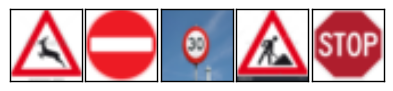

In [13]:
import glob
from scipy import misc
from PIL import Image

filename = (glob.glob('ownimages/*')) 
fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for i in range(len(filename)):
    ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
    img1 = misc.imread(filename[i],flatten=False)
    img2 = (np.array(misc.imresize(img1,(32,32,3))))
    if (i == 0) :
        Xown = np.array([img2])
    else:
        img3= np.array([img2])
        Xown=np.append(Xown,img3,axis=0)
    ax.imshow(img2,cmap='gray')
plt.show()
temp1 = (np.sum(Xown/3, axis=3, keepdims=True))
Xown=temp1

In [14]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    new_predictions = sess.run(predictions, feed_dict={x: Xown, keep_prob: 1.0})
    print(sess.run(tf.argmax(new_predictions,1)))
    k=(sess.run(tf.nn.top_k(predictions, 5), feed_dict={x: Xown, keep_prob: 1.0}))
    print (k)

[31 17 11 25 14]
TopKV2(values=array([[  1.00000000e+00,   3.42792887e-08,   1.42400633e-10,
          1.16771523e-10,   2.36948438e-12],
       [  9.99169827e-01,   3.74832161e-04,   2.19140100e-04,
          5.62995883e-05,   5.06946926e-05],
       [  5.83649993e-01,   2.71332920e-01,   4.20831554e-02,
          3.88030931e-02,   2.69322414e-02],
       [  1.00000000e+00,   8.97943386e-11,   6.28405036e-11,
          2.03147724e-11,   6.04691774e-12],
       [  6.57804906e-01,   2.26267785e-01,   1.14678301e-01,
          5.82464389e-04,   2.06356650e-04]], dtype=float32), indices=array([[31, 21,  1, 40, 18],
       [17, 13, 15,  8, 33],
       [11,  8,  5, 16, 36],
       [25, 11, 26, 20, 36],
       [14,  4, 18, 25, 26]], dtype=int32))


### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


### ANSWER

Model accuracy for the new images is 80%. One image not classified correctly, as originally suspected (30 mph speed limit). It is surmised that the bacground and other elements of the image may be the root-cause. Correct classfication does happend for this image also, but with a lower probability, as shown in the softmax probabilities below. 80% is lower than the test and training data accuracy, as I expected.


### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

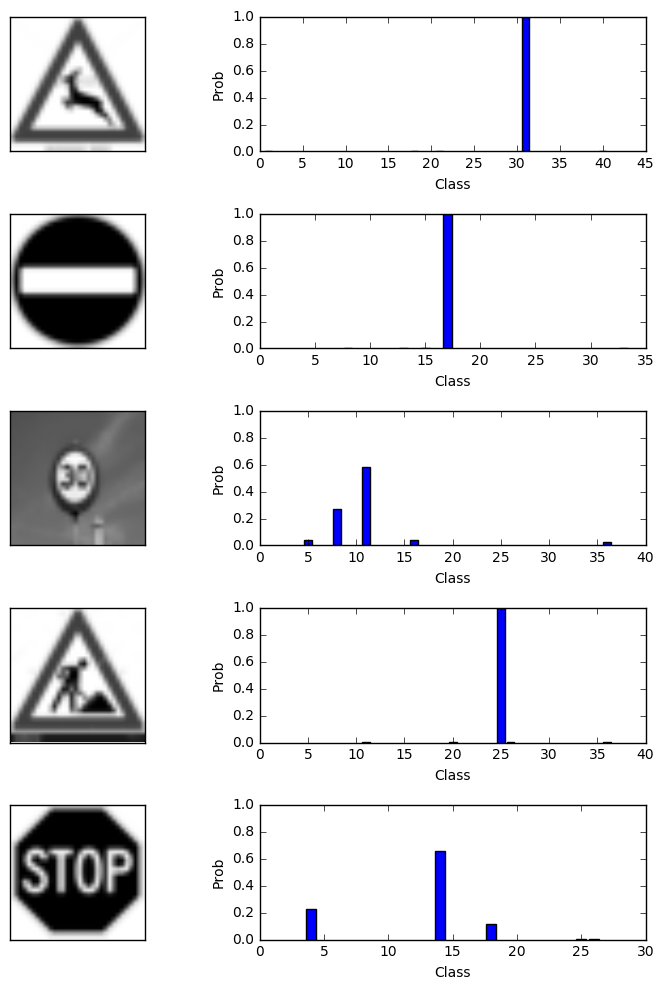

In [15]:
fig = plt.figure(figsize=(8,10))
for i in np.arange(k.values.shape[0]):
    ax = fig.add_subplot(k.values.shape[0],2, 2*(i + 1)-1,xticks=[],yticks=[])
    ax.imshow(Xown[i].squeeze(),cmap='gray')
    ax = fig.add_subplot(k.values.shape[0],2, 2*(i + 1))
    x=k.indices[i]
    y=k.values[i]
    ax.bar(x,y,align='center')
    ax.set_xlim (left=0)
    ax.set_ylim (bottom=0,top=1)
    ax.set_yticks(np.arange(0,1.1,0.2))
    ax.set_xlabel('Class')
    ax.set_ylabel('Prob')
plt.tight_layout()
plt.show()

### ANSWER
The model is 80% certain of the signs provided. 3 of 5 signs are classified with 0.99 probability. The Stop Sign is classified with 0.75 probability. The 30 speed sign is classfied incorrectly with a 0.8 probability. This could be due to the background elements in the image as seen.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.